<a href="https://colab.research.google.com/github/chekwube-ononuju/-Analyzing-Historical-Stock-Data/blob/main/Chekwube_Ononuju_R11872197.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text Classification Assignment:** Distinguishing Human-Written vs. AI-Generated Text<br>
**Author:** Chekwube Ononuju<br>
**Date:** 06/06/2025

In [21]:

#imports
import warnings
warnings.filterwarnings("ignore")  # keep the console clean
import os
import joblib  #to save models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score,precision_recall_fscore_support,classification_report,confusion_matrix,RocCurveDisplay)

In [39]:
#NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
CONFIG = {
    "seed": 42,
    "test_size": 0.2,                 #part of train set we will use for validation
    "tfidf_max_features": 25_000,     #vocabulary size (speed vs. accuracy)
    "export_predictions": "Chekwube_Ononuju_test_R11872197.csv",  #output file name
}
np.random.seed(CONFIG["seed"])
os.makedirs("figures", exist_ok=True)  #for plots

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:

#Assignment Task 1 - data loading and exploring
from google.colab import drive
drive.mount('/content/drive')

def load_data(train_path="/content/drive/MyDrive/AI_vs_huam_train_dataset (2).xlsx", test_path="/content/drive/MyDrive/Final_test_data (1).csv"):
    train_df = pd.read_excel(train_path)
    test_df  = pd.read_csv(test_path)
    return train_df, test_df
def explore_data(df: pd.DataFrame):
    print(f"Total samples      : {len(df):,}")
    label_counts = df["label"].value_counts().sort_index()
    print("Class distribution :")
    for lbl, cnt in label_counts.items():
        print(f"  ▸ {lbl} → {cnt:,} ({cnt/len(df):.1%})")
    #bar plot for class balance
    plt.figure()
    sns.countplot(x="label", data=df, palette="Set2")
    plt.title("Class distribution (Human=0, AI=1)")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.savefig("figures/class_distribution.png", dpi=300, bbox_inches="tight")
    plt.close()
    print("➤ Saved plot → figures/class_distribution.png")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#Assignment Task 2- text preprocessing

STOP_WORDS = set(stopwords.words("english"))
def remove_stop_words(text: str, stop_words=STOP_WORDS):
    tokens = [w for w in text.split() if w.lower() not in stop_words]
    return " ".join(tokens)
PORTER     = PorterStemmer()
SNOWBALL   = SnowballStemmer("english")
LANCASTER  = LancasterStemmer()
LEMMATISER = WordNetLemmatizer()
def preprocess_series(text_series: pd.Series):
    """Apply lower-casing + stop-word removal."""
    return text_series.str.lower().apply(remove_stop_words)

In [25]:
#Assignment Task 3 - feature extraction
def make_vectorisers(max_features=CONFIG["tfidf_max_features"]):
    tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=max_features, min_df=2, max_df=0.9)
    bow   = CountVectorizer(ngram_range=(1,3), max_features=max_features, min_df=2, max_df=0.9)
    return tfidf, bow

In [26]:
#Task 4-model training & hyper parameter tuning

def tune_svm(X_train, y_train):
    grid = GridSearchCV(SVC(probability=True),{"C":[0.1,1,10], "kernel":["linear","rbf"]},cv=5, n_jobs=-1, scoring="accuracy")
    grid.fit(X_train, y_train)
    print("Best SVM params:", grid.best_params_)
    return grid.best_estimator_
def tune_decision_tree(X_train, y_train):
    param_grid = {"criterion": ["gini","entropy"],"max_depth": [None,10,20,30],"min_samples_split": [2,10,20],"min_samples_leaf": [1,5,10]}
    grid = GridSearchCV(DecisionTreeClassifier(random_state=CONFIG["seed"]),param_grid, cv=5, n_jobs=-1, scoring="accuracy")
    grid.fit(X_train, y_train)
    print("Best DT params:", grid.best_params_)
    return grid.best_estimator_

In [27]:
#Task 5- evaluating
def evaluate(model, X_val, y_val, name="Model"):
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_val, y_pred, average="weighted")
    print(f"{name} — Acc:{acc:.3f}  Prec:{pr:.3f}  Rec:{rc:.3f}  F1:{f1:.3f}")
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()
    return f1

In [28]:
if __name__ == "__main__":
    train_df, test_df = load_data()
    explore_data(train_df)

Total samples      : 3,728
Class distribution :
  ▸ 0 → 1,864 (50.0%)
  ▸ 1 → 1,864 (50.0%)
➤ Saved plot → figures/class_distribution.png


In [29]:
# clean text
train_df["essay"] = preprocess_series(train_df["essay"])
test_df["essay"]  = preprocess_series(test_df["essay"])


In [30]:
# vectorise
tfidf_vec, _ = make_vectorisers()
X = tfidf_vec.fit_transform(train_df["essay"])
y = train_df["label"].values

In [31]:
#split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=CONFIG["test_size"], random_state=CONFIG["seed"], stratify=y)

In [32]:
#train models
svm = tune_svm(X_train, y_train)
dt  = tune_decision_tree(X_train, y_train)

Best SVM params: {'C': 10, 'kernel': 'linear'}
Best DT params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


SVM — Acc:0.981  Prec:0.981  Rec:0.981  F1:0.981


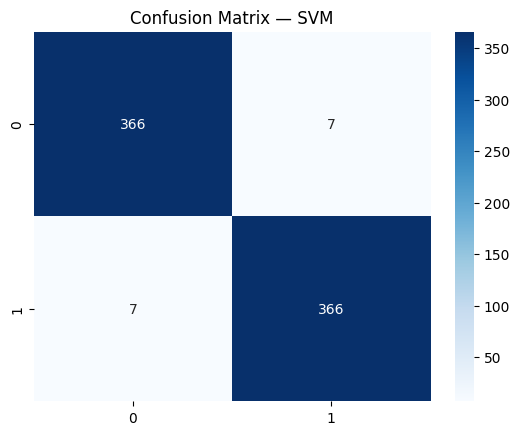

DecisionTree — Acc:0.936  Prec:0.936  Rec:0.936  F1:0.936


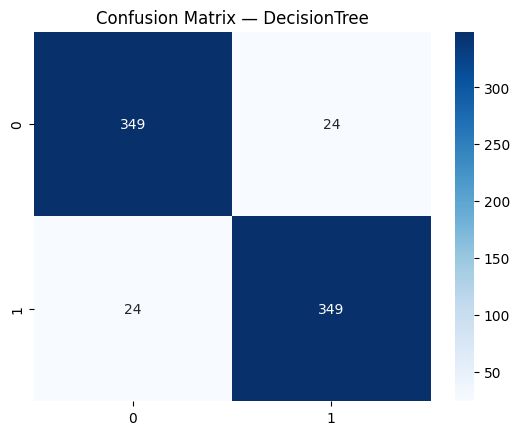

In [33]:
#evaluate
f1_svm = evaluate(svm, X_val, y_val, "SVM")
f1_dt  = evaluate(dt,  X_val, y_val, "DecisionTree")

In [34]:
#choose best
best = svm if f1_svm >= f1_dt else dt
print(f"Using {'SVM' if best is svm else 'Decision Tree'} for final training.")

Using SVM for final training.


In [35]:
#retrain on full data
best.fit(X, y)
joblib.dump(best, "best_model.joblib")
joblib.dump(tfidf_vec, "tfidf_vectoriser.joblib")

['tfidf_vectoriser.joblib']

In [ ]:
#predict on test
X_test = tfidf_vec.transform(test_df["essay"])
preds = best.predict(X_test)
output = pd.DataFrame({"essay_id": test_df.get("essay_id", test_df.index),"predicted_label": preds})

In [43]:
output.to_csv(CONFIG["export_predictions"], index=False)
print(f"\nPrediction file created → {CONFIG['export_predictions']}")


Prediction file created → Chekwube_Ononuju_test_R11872197.csv
